In [1]:
import os
import sys
sys.path.append(os.getcwd())

from tumorpde.models.growth import TumorInfiltraFD
from tumorpde.volume_domain import VolumeDomain

import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)
print(f"The current device is: {device}")

from datetime import datetime
import pandas as pd
import numpy as np
from scipy.ndimage import zoom

from expriment_helpers import read_patient_data, weighted_center
from expriment_helpers import visualize_model_fit_2d
from expriment_helpers import ndarray_from_nifty, binarize_img
from expriment_helpers import append_parameters_to_file

import matplotlib.pyplot as plt


The current device is: cpu


In [2]:
patient = "LIU-TONG"
ref = 2

dir_path = "../data/PatienTumorMultiScan2024/"
raw_t1, aff_info, header = ndarray_from_nifty(os.path.join(
    dir_path, patient, f'{patient}{ref}_t1_resized.nii.gz'))
tumor1, _, _ = ndarray_from_nifty(os.path.join(
    dir_path, patient, f'{patient}{ref}_t1mask_resized.nii.gz'))
tumor1 = binarize_img(tumor1)

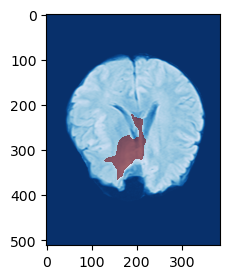

In [4]:
slice_idx = 90

plt.figure(figsize=(3,3))
plt.imshow(raw_t1[:,:,slice_idx].T, cmap="Blues_r")
tumor_sl = tumor1[:,:,slice_idx]
plt.imshow(np.ma.masked_where(tumor_sl < 1e-4, tumor_sl).T, cmap="Reds_r", alpha=0.6)
plt.show()

In [5]:
del tumor_sl

In [6]:

raw_t1 = raw_t1[:,:,slice_idx]
tumor1 = tumor1[:,:,slice_idx]
brain, _, _ = ndarray_from_nifty(os.path.join(
    dir_path, patient, f'{patient}{ref}_brain_normalized.nii.gz'))
brain = brain[:,:,slice_idx]
gm, _, _ = ndarray_from_nifty(os.path.join(
    dir_path, patient, f'{patient}{ref}_gm_normalized.nii.gz'))
gm = gm[:,:,slice_idx]
wm, _, _ = ndarray_from_nifty(os.path.join(
    dir_path, patient, f'{patient}{ref}_wm_normalized.nii.gz'))
wm = wm[:,:,slice_idx]
csf, _, _ = ndarray_from_nifty(os.path.join(
    dir_path, patient, f'{patient}{ref}_csf_normalized.nii.gz'))
csf = csf[:,:,slice_idx]

ref = 3
tumor2, _, _ = ndarray_from_nifty(os.path.join(
    dir_path, patient, f'{patient}{ref}_t1mask_resized.nii.gz'))
tumor2 = tumor2[:,:,slice_idx]
tumor2 = binarize_img(tumor2)

In [7]:
# shrink the size
zoom_factors = 0.3

zoom_factors = tuple([zoom_factors]*2)
brain = zoom(brain, zoom_factors, order=1)
raw_t1 = zoom(raw_t1, zoom_factors, order=1)
gm = zoom(gm, zoom_factors, order=1)
wm = zoom(wm, zoom_factors, order=1)
csf = zoom(csf, zoom_factors, order=1)
tumor1 = zoom(tumor1, zoom_factors, order=1)
tumor2 = zoom(tumor2, zoom_factors, order=1)


In [8]:
tumor_list = [tumor1, tumor2]
res_path = "./results"

print(f"Tumor array shape: {tumor_list[0].shape}")
print(f"Brain array shape: {raw_t1.shape}")

# formulate the diffusivity field
print(f"Max check > gm: {gm.max()}, wm: {wm.max()}, csf: {csf.max()}")
print(f"Min check > gm: {gm.min()}, wm: {wm.min()}, csf: {csf.min()}")
vox = (0.01 * gm + 0.9 * wm + 0.001 * csf).copy()
# del gm, wm, csf

# Define the spatial domain
# assume the voxel has equal width along each axis pixel
# this is only valid when the image has been properly re-scaled
geom = VolumeDomain(vox, [1.,1.])

# Define the time domain
t0, t1 = 0., 1.


Tumor array shape: (115, 154)
Brain array shape: (115, 154)
Max check > gm: 0.9999374031111566, wm: 0.9999999948056955, csf: 0.9999173349189233
Min check > gm: 0.0, wm: 0.0, csf: 0.0


In [9]:
D = 50.
rho = 4.

def init_density_func(x, rmax = 0.1):
    return rmax * torch.as_tensor(tumor_list[0], device=device)

init_density_params = {"rmax": 0.5}

fd_pde = TumorInfiltraFD(
    geom, D, rho,
    init_density_func=init_density_func,
    init_other_params=init_density_params, device=device)

plot_dir = os.path.join(res_path, f"plots_fixinit_D{int(D)}_rho{int(rho)}", patient)
os.makedirs(plot_dir, exist_ok=True)


In [10]:

u, _, _ = fd_pde.solve(
    dt=0.001, t1=1.2 * t1, D=D, rho=rho,
    plot_func=visualize_model_fit_2d, plot_period=50,
    plot_args = {'save_dir': plot_dir, 'file_prefix': patient,
                "brain": vox, "tumor1": tumor_list[0], "tumor2": tumor_list[-1],
                "show": False, "main_title": patient},
    save_all=False)

Forward Simulation: 100%|██████████| 1200/1200 [00:02<00:00, 588.22it/s]
